In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Preprocessing the data

In [2]:
train_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train"
test_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Test"
valid_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Validation"
train_dir_augmented = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train_augmented"

# Setup data inputs
IMG_SIZE = 144

#import data from directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = True,
                                                                seed = 42)

train_data_augmented = tf.keras.preprocessing.image_dataset_from_directory(train_dir_augmented,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = True,
                                                                seed = 42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = False) # don't shuffle test data for prediction analysis

valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = False) # don't shuffle test data for prediction analysis
train_data

Found 19173 files belonging to 7 classes.
Found 23846 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 144, 144, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [3]:
class_names = train_data.class_names
class_names

['Atelectasis',
 'Effusion',
 'Infiltration',
 'Mass',
 'No_finding',
 'Nodule',
 'Pneumothorax']

## Preprocessing the dataset

In [4]:
#Creating a function to preprocess the images
def preprocess_img(image, label):
  """
  Converts image datatype from 'uint8' -> 'float32' 
  """
  return tf.cast(image, tf.float32), label 

In [5]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE) 
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Map prepreprocessing function to validation data
valid_data = valid_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Map prepreprocessing function to augmented training data
train_data_augmented = train_data_augmented.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
train_data_augmented = train_data_augmented.prefetch(buffer_size = tf.data.AUTOTUNE)

# Creating checkpoint callback

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='fine_tuning_best_model.h5',
    save_weights_only=False,  
    monitor='val_accuracy',  
    save_best_only=True, 
    verbose=1  
)

# Fine tuning model

In [7]:
from tensorflow.keras import layers, Model, regularizers

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    #import the base model
    base_model = tf.keras.applications.efficientnet.EfficientNetB6(include_top=False)
    base_model.trainable = True

    inputs = tf.keras.Input((IMG_SIZE,IMG_SIZE,3), name='inputs') 
    #data augmentation
    # x = layers.Rescaling(1/.255)(inputs)
    x = layers.RandomFlip('horizontal')(inputs)
    x = layers.RandomBrightness(0.4)(x)
    x = layers.RandomContrast(0.4)(x)
    x = layers.RandomRotation(0.05)(x)
    # Using efficientnet model
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    #outputs
    outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

    fine_tuning_model = tf.keras.Model(inputs = inputs, outputs = outputs)
    #compile the model
    fine_tuning_model.compile(
                                optimizer = tf.keras.optimizers.Adam(), 
                                loss = tf.keras.losses.categorical_crossentropy,
                                metrics = ['accuracy']
        )

165234480/165234480 [==============================] - 1s 0us/step


In [ ]:
import random 
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
  
history_fine_tuning = fine_tuning_model.fit(
                                    train_data_augmented,
                                    epochs=8,
                                    validation_data=valid_data,
                                    validation_steps=len(valid_data),
                                    callbacks=[checkpoint_callback]
)

Epoch 1/8


2024-01-21 21:22:51.154954: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb6/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


746/746 [==============================] - ETA: 0s - loss: 1.7079 - accuracy: 0.3433
Epoch 1: val_accuracy improved from -inf to 0.32217, saving model to fine_tuning_best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


746/746 [==============================] - 517s 410ms/step - loss: 1.7079 - accuracy: 0.3433 - val_loss: 1.9629 - val_accuracy: 0.3222
Epoch 2/8
746/746 [==============================] - ETA: 0s - loss: 1.5319 - accuracy: 0.4314
Epoch 2: val_accuracy improved from 0.32217 to 0.38030, saving model to fine_tuning_best_model.h5
746/746 [==============================] - 300s 400ms/step - loss: 1.5319 - accuracy: 0.4314 - val_loss: 1.7131 - val_accuracy: 0.3803
Epoch 3/8
746/746 [==============================] - ETA: 0s - loss: 1.4373 - accuracy: 0.4753
Epoch 3: val_accuracy did not improve from 0.38030
746/746 [==============================] - 297s 396ms/step - loss: 1.4373 - accuracy: 0.4753 - val_loss: 1.8372 - val_accuracy: 0.3581
Epoch 4/8
746/746 [==============================] - ETA: 0s - loss: 1.3493 - accuracy: 0.5088
Epoch 4: val_accuracy did not improve from 0.38030
746/746 [==============================] - 296s 395ms/step - loss: 1.3493 - accuracy: 0.5088 - val_loss: 1.885

# Evaluate the model

In [10]:
fine_tuning_model = tf.keras.models.load_model(r'C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\6_saved_models\fine_tuning_best_model_144p_2.h5')
fine_tuning_model.evaluate(test_data)

64/64 [==============================] - 100s 1s/step - loss: 1.8932 - accuracy: 0.3621


[1.89321768283844, 0.36206895112991333]

## Confusion matrix

In [11]:
from helper_functions import plot_confusion_matrix

# Create valid labels and predictions
valid_labels = []
for images, labels in valid_data.unbatch():
  valid_labels.append(tf.argmax(labels).numpy())
valid_pred_probs = fine_tuning_model.predict(valid_data)
valid_predictions = tf.argmax(valid_pred_probs, axis=1)

64/64 [==============================] - 109s 2s/step


array([[0.46896552, 0.09655172, 0.04482759, 0.00344828, 0.14827586,
        0.13793103, 0.1       ],
       [0.12068966, 0.54827586, 0.09655172, 0.01034483, 0.0862069 ,
        0.04827586, 0.08965517],
       [0.2       , 0.1       , 0.16206897, 0.04827586, 0.25517241,
        0.14137931, 0.09310345],
       [0.10344828, 0.07586207, 0.06896552, 0.33793103, 0.11724138,
        0.23793103, 0.05862069],
       [0.16551724, 0.07586207, 0.07241379, 0.02413793, 0.32413793,
        0.16896552, 0.16896552],
       [0.12413793, 0.02758621, 0.09310345, 0.08275862, 0.18275862,
        0.42068966, 0.06896552],
       [0.10344828, 0.07931034, 0.0862069 , 0.01724138, 0.1137931 ,
        0.0862069 , 0.5137931 ]])

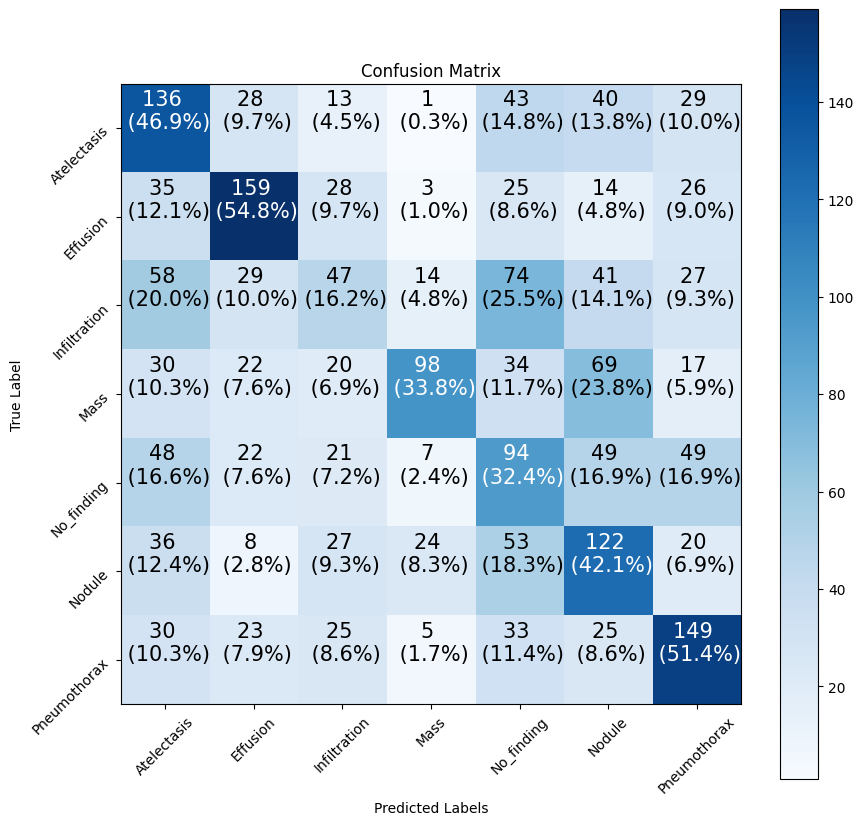

In [12]:
plot_confusion_matrix(valid_labels, valid_predictions, class_names)